# Sound source localization using grid search

In this notebook, we perform SSL using grid search. The setup is as follows: the user enters the dimensions $x * y * z $ of the Shoebox room and places the microphone inside this room. Then we create a grid of size $ (2*x+1) * (2*y+1) * (2*z+1) $, where each element in this grid represents a sound source position. For each of these position we compute the Room Impulse Response between the sound source and the fixed microphone. All of these sources emit white gaussian noise of frequency $f_s = 16 kHz$ and duration $1$ second. The flat frequency content of a WGN signal makes it a better training signal, due to its ability to fully excite the frequency response of the AIR [1].

Once these preprocessing steps are done, we will have a dictionnary with the different positions in the grid and their respective room impulse response. This will constitute our training set

Afterwards, the user places a sound source in the room. We compute the RIR and perform a cross correlation with all the different RIRs in the training set and select the top 3 positions in the dictionnary (ie. the most similar).

1. [Pre-processing steps](#pps)
2. [Sound Source Localization](#ssl)
3. [Visualization](#visu)

<a id='pps'></a>
#### 1. Pre-processing steps

Import necessary libraries

In [1]:
import pyroomacoustics as pra
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
from helpers import *
from mpl_toolkits import mplot3d
%load_ext autoreload
%autoreload 2
%matplotlib inline

Choose Room Setup

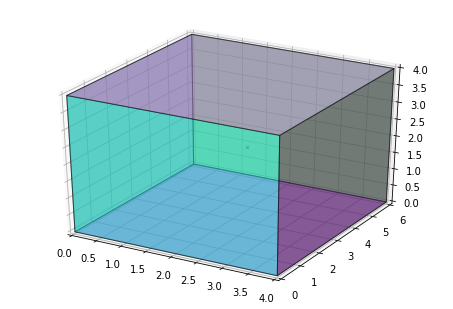

In [2]:
#Room dimensions
room_dimX, room_dimY, room_dimZ = 4, 6, 4

#Sampling frequency
fs = 16000 # 16kHz

#Microphone position
micX, micY, micZ = 2.2, 3.2, 2.1 # mic in the center of the room


room = pra.ShoeBox([room_dimX,room_dimY], fs=fs, max_order = 4, absorption=0.2)
room.extrude(room_dimZ)

R = np.array([[micX],[micY],[micZ]])

room.add_microphone_array(pra.MicrophoneArray(R, room.fs))


# Visualize setup
fig, ax = room.plot()
ax.set_xlim([0, 4])
ax.set_ylim([0, 6])
ax.set_zlim([0, 4]);

Create the grid for the different positions of the sound sources

In [3]:
grid_samples = (2*room_dimX+1) * (2*room_dimY+1) * (2*room_dimZ+1)

grid1 = np.linspace(0, room_dimX, num=2*room_dimX+1)
grid2 = np.linspace(0, room_dimY, num=2*room_dimY+1)
grid3 = np.linspace(0, room_dimZ, num=2*room_dimZ+1)

grid = cartesian_product(grid1, grid2, grid3)

Input audio signal for all sound sources in grid

In [4]:
signal_train = awgn(fs=16000, duration=1) 

Create the training set with the RIR of different sound source positions

In [5]:
train = create_training_set(grid, signal_train, Xdim=room_dimX, Ydim=room_dimY, Zdim=room_dimZ, mic_pos=np.array([[micX],[micY],[micZ]]), fs=fs)

100%|██████████| 1053/1053 [00:18<00:00, 55.92it/s]


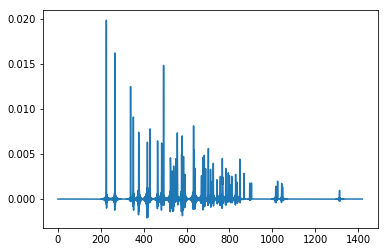

In [6]:
rir_example = train[6]
plt.plot(rir_example[0][0])
plt.show()

<a id='ssl'></a>
#### 2. Sound Source Localization

Users now enters the position of the speaker and the input audio

In [7]:
_, signal = wavfile.read("test1.wav")

posX, posY, posZ = 0.9, 3.5, 1.7

source_pos = np.array([posX, posY, posZ])

room = pra.ShoeBox([room_dimX,room_dimY], fs=fs, max_order = 4, absorption=0.2)
room.extrude(room_dimZ)
R = np.array([[micX],[micY],[micZ]])

room.add_microphone_array(pra.MicrophoneArray(R, room.fs))

room.add_source(source_pos, signal=signal)

room.image_source_model(use_libroom=False)
room.compute_rir()

rir = room.rir

We compute the similarities between the above RIR and all the RIR of the training set. We select the 3 most similar ones and outputs their respective positions

In [8]:
top3 = compute_similarities(rir[0][0], train)
for i,pos in enumerate(grid[top3,:]):
    print('Guess n°{i} : {pos}'.format(i=i+1, pos= pos))
print('Ground truth : {gpos}'.format(gpos=source_pos))

Guess n°1 : [3.5 3.5 2.5]
Guess n°2 : [2.5 4.5 2.5]
Guess n°3 : [1.  2.5 2. ]
Ground truth : [0.9 3.5 1.7]


Compute distances to ground truth

In [9]:
for i,pos in enumerate(grid[top3,:]):
    print('L2 Distance of guess n°{i} : {pos}m'.format(i=i+1, pos=np.linalg.norm(pos - source_pos,)))


L2 Distance of guess n°1 : 2.7202941017470885m
L2 Distance of guess n°2 : 2.04939015319192m
L2 Distance of guess n°3 : 1.0488088481701516m


<a id='visu'></a>
#### 3. Visualization

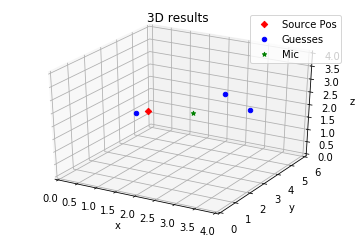

In [10]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlim(0,room_dimX)
ax.set_ylim(0,room_dimY)
a = ax.set_zlim(0,room_dimZ)

sca1 = ax.scatter3D(posX, posY, posZ, c='r', marker='D');
guesses = grid[top3,:]

sca2 = ax.scatter3D(guesses[:,0], guesses[:,1], guesses[:,2], c='b', marker='o', depthshade=False)

sca3 = ax.scatter3D(micX, micY, micZ, c='g', marker='*');

plt.legend((sca1, sca2, sca3), ('Source Pos', 'Guesses', 'Mic'), loc=0)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.title('3D results')
plt.show()
